In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import TensorDataset, DataLoader

/home/nicek/Projects/multitask_learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_name = "all-MiniLM-L6-v2"
# model = SentenceTransformer(f"sentence-transformers/{model_name}")
# embedding_size = model.get_sentence_embedding_dimension()
# embedding = model.encode(text, convert_to_numpy=True)

In [3]:
def low_rank_approximation(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    embedding_k = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
    return embedding_k

In [4]:
def low_rank_projection(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    Z = U[:, :k] * S[:k] 
    return Z

In [5]:
def random_projection(latent: np.ndarray, k: int):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    R = np.random.randn(384, k) / np.sqrt(k)
    return latent @ R

In [6]:
def plot_proj_default(latent: np.ndarray, labels: np.ndarray):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    latent_2d = PCA(n_components=2).fit_transform(latent)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter( latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Label ID")
    plt.title("Plot 2d Random Projection")
    plt.show()

In [7]:
def plot_random_proj(latent: np.ndarray, k: int):
    latent_randp = random_projection(latent, k)
    latent_2d = PCA(n_components=2).fit_transform(latent_randp)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter( latent_2d[:, 0], latent_2d[:, 1], cmap="tab20", s=10, alpha=0.7)
    plt.colorbar(scatter, label="Label ID")
    plt.title("Plot 2d Random Projection")
    plt.show()
    pass

In [8]:
def make_dataloader(X, y, batch_size=64):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class ClassiNet(nn.Module):
    def __init__(self, input_dim, num_label=2):
        super(ClassiNet, self).__init__()
        self.classi = nn.Linear(input_dim, num_label)
    
    def forward(self, x):
        return self.classi(x)

epochs = 10

# One pass
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data, label in loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

In [10]:
# Nested dim
K = [2, 4, 8, 16, 32, 64, 128, 256]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # data = random_projection()
    # data = low_rank_projection()
    # data = low_rank_approximation()

    print(f"\n[LOG] Running for {k = }")
    X_low = low_rank_projection(X, k)
    # X_low = random_projection(X, k)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

# plot_proj_default(X, y)


[LOG] Running for k = 2
Epoch 5: Loss=0.4470 | Test Acc=86.20%
Epoch 10: Loss=0.3899 | Test Acc=87.80%

[LOG] Running for k = 4
Epoch 5: Loss=0.5391 | Test Acc=83.10%
Epoch 10: Loss=0.4187 | Test Acc=88.80%

[LOG] Running for k = 8
Epoch 5: Loss=0.4087 | Test Acc=87.40%
Epoch 10: Loss=0.3718 | Test Acc=88.20%

[LOG] Running for k = 16
Epoch 5: Loss=0.5088 | Test Acc=86.00%
Epoch 10: Loss=0.4044 | Test Acc=88.40%

[LOG] Running for k = 32
Epoch 5: Loss=0.4470 | Test Acc=88.10%
Epoch 10: Loss=0.3831 | Test Acc=88.30%

[LOG] Running for k = 64
Epoch 5: Loss=0.4568 | Test Acc=86.90%
Epoch 10: Loss=0.3860 | Test Acc=87.60%

[LOG] Running for k = 128
Epoch 5: Loss=0.4494 | Test Acc=86.00%
Epoch 10: Loss=0.3771 | Test Acc=87.90%

[LOG] Running for k = 256
Epoch 5: Loss=0.4366 | Test Acc=83.90%
Epoch 10: Loss=0.3611 | Test Acc=85.50%


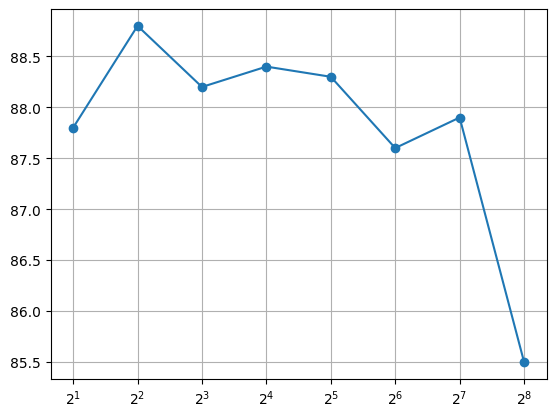

In [ ]:
dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank projection")
plt.xscale('log', base=2)
plt.show()



[LOG] Running for k = 2
(5000, 2)
Epoch 5: Loss=0.6926 | Test Acc=51.90%
Epoch 10: Loss=0.6908 | Test Acc=52.90%

[LOG] Running for k = 4
(5000, 4)
Epoch 5: Loss=0.6950 | Test Acc=51.30%
Epoch 10: Loss=0.6929 | Test Acc=51.70%

[LOG] Running for k = 8
(5000, 8)
Epoch 5: Loss=0.6668 | Test Acc=59.60%
Epoch 10: Loss=0.6600 | Test Acc=60.00%

[LOG] Running for k = 16
(5000, 16)
Epoch 5: Loss=0.6776 | Test Acc=60.10%
Epoch 10: Loss=0.6650 | Test Acc=59.00%

[LOG] Running for k = 32
(5000, 32)
Epoch 5: Loss=0.6575 | Test Acc=65.00%
Epoch 10: Loss=0.6398 | Test Acc=64.90%

[LOG] Running for k = 64
(5000, 64)
Epoch 5: Loss=0.6567 | Test Acc=66.60%
Epoch 10: Loss=0.6326 | Test Acc=67.10%

[LOG] Running for k = 128
(5000, 128)
Epoch 5: Loss=0.6285 | Test Acc=74.80%
Epoch 10: Loss=0.5858 | Test Acc=75.80%

[LOG] Running for k = 256
(5000, 256)
Epoch 5: Loss=0.6068 | Test Acc=78.20%
Epoch 10: Loss=0.5501 | Test Acc=79.40%


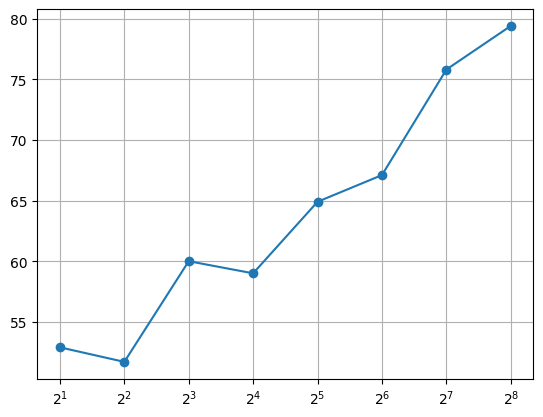

In [ ]:
# Nested dim
K = [2, 4, 8, 16, 32, 64, 128, 256]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    # data = random_projection()
    # data = low_rank_projection()
    # data = low_rank_approximation()

    print(f"\n[LOG] Running for {k = }")
    # X_low = low_rank_projection(X, k)
    X_low = random_projection(X, k)
    print(X_low.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.title("Random Projection")
plt.grid(True)
plt.xscale('log', base=2)
plt.show()



[LOG] Running for k = 2
(5000, 384)
Epoch 5: Loss=0.3667 | Test Acc=88.50%
Epoch 10: Loss=0.3614 | Test Acc=88.70%

[LOG] Running for k = 4
(5000, 384)
Epoch 5: Loss=0.3676 | Test Acc=88.50%
Epoch 10: Loss=0.3606 | Test Acc=88.50%

[LOG] Running for k = 8
(5000, 384)
Epoch 5: Loss=0.3746 | Test Acc=88.00%
Epoch 10: Loss=0.3601 | Test Acc=88.10%

[LOG] Running for k = 16
(5000, 384)
Epoch 5: Loss=0.3805 | Test Acc=88.30%
Epoch 10: Loss=0.3618 | Test Acc=88.60%

[LOG] Running for k = 32
(5000, 384)
Epoch 5: Loss=0.3859 | Test Acc=88.30%
Epoch 10: Loss=0.3602 | Test Acc=88.50%

[LOG] Running for k = 64
(5000, 384)
Epoch 5: Loss=0.3927 | Test Acc=87.70%
Epoch 10: Loss=0.3609 | Test Acc=88.20%

[LOG] Running for k = 128
(5000, 384)
Epoch 5: Loss=0.3970 | Test Acc=87.90%
Epoch 10: Loss=0.3541 | Test Acc=88.40%

[LOG] Running for k = 256
(5000, 384)
Epoch 5: Loss=0.4120 | Test Acc=86.00%
Epoch 10: Loss=0.3509 | Test Acc=85.90%


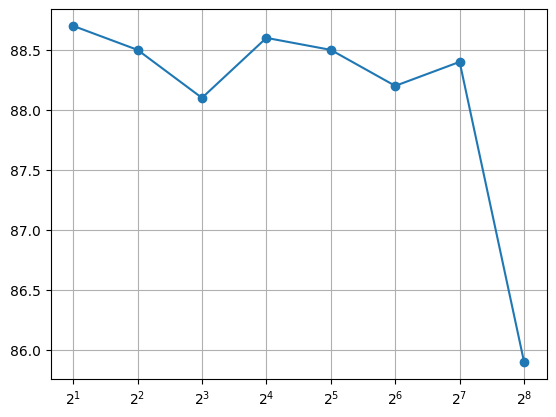

In [ ]:
# Nested dim
K = [2, 4, 8, 16, 32, 64, 128, 256]
X, y = make_classification(
    n_samples=5000,
    n_features=384,
    n_classes=2,
    random_state=42
)
# X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# X, y = make_circles(n_samples=500, noise=0.2, random_state=42)
results = []

for k in K:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\n[LOG] Running for {k = }")
    # X_low = low_rank_projection(X, k)
    # X_low = random_projection(X, k)
    X_low = low_rank_approximation(X, k)
    print(X_low.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X_low, y, test_size=0.2, random_state=42, stratify=y
    )
    train_loader = make_dataloader(X_train, y_train)
    test_loader = make_dataloader(X_test, y_test)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ClassiNet(384).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank approximation")
plt.xscale('log', base=2)
plt.show()
